# Multi-Label Classification

### The Data

In [ ]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [ ]:
df = pd.read_csv(path/'train.csv')
df.head(5)

In [ ]:
valid = df[df.is_valid == True]
not_valid = df[df.is_valid == False]

In [ ]:
tmp_df = pd.DataFrame({'a':[1,2], 'b':[3,4]})
tmp_df

In [127]:
tmp_df['c'] = np.multiply(tmp_df.a, tmp_df.b)

In [128]:
tmp_df

,a,b,c
0,1,3,3
1,2,4,8


## constructing a DataBlock

In [129]:
dblock = DataBlock()
dsets = dblock.datasets(df)

In [130]:
len(dsets.train), len(dsets.valid)

(4009, 1002)

In [131]:
x, y = dsets.train[0]
x, y

(fname                  005122.jpg
 labels      bicycle person bottle
 is_valid                    False
 Name: 2566, dtype: object,
 fname                  005122.jpg
 labels      bicycle person bottle
 is_valid                    False
 Name: 2566, dtype: object)

In [132]:
def get_x(r): return r.fname
def get_y(r): return r.labels

dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)

dsets.train[0]

('000519.jpg', 'boat')

In [ ]:
def get_x(r): return path/'train'/r.fname
def get_y(r): return r.labels.split(' ')


In [134]:
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/root/.fastai/data/pascal_2007/train/000656.jpg'), ['dog'])

In [ ]:
# we need to replace categoryblock with multicategoryblock

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                      get_x = get_x, get_y = get_y)

dsets = dblock.datasets(df)
x, y = dsets.train[0]
print(y)
x.show();

In [ ]:
idxs = torch.where(dsets.train[0][1] == 1.)[0]
print(idxs)
dsets.train.vocab[idxs]

In [136]:
def splitter(df):
    train = df.index[~df.is_valid].tolist()
    valid = df.index[df.is_valid].tolist()
    return train, valid

In [137]:
dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                      splitter = splitter,
                      get_x = get_x,
                      get_y = get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

In [138]:
dblock = DataBlock(
            blocks = (ImageBlock, MultiCategoryBlock),
            splitter = splitter,
            get_x = get_x,
            get_y = get_y,
            item_tfms = Resize(500)
)

dls = dblock.dataloaders(df)

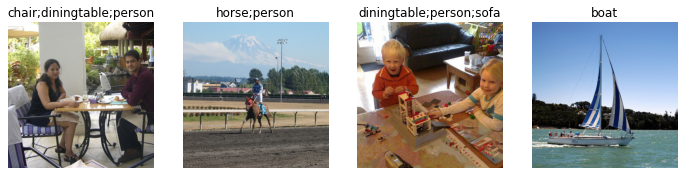

In [139]:
dls.train.show_batch(nrows = 1, ncols=4)

In [140]:
dblock.summary(df)

Setting-up type transforms pipelines
0     000005.jpg           chair      True
1     000007.jpg             car      True
2     000009.jpg    horse person      True
3     000012.jpg             car     False
4     000016.jpg         bicycle      True
...          ...             ...       ...
5006  009954.jpg    horse person      True
5007  009955.jpg            boat      True
5008  009958.jpg  person bicycle      True
5009  009959.jpg             car     False
5010  009961.jpg             dog     False

[5011 rows x 3 columns]
Found 5011 items
2 datasets of sizes 2501,2510
Setting up Pipeline: get_x -> PILBase.create
Setting up Pipeline: get_y -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}

Building one sample
  Pipeline: get_x -> PILBase.create
    starting from
      fname       000012.jpg
labels             car
is_valid         False
Name: 3, dtype: object
    applying get_x gives
      /root/.fastai/data/pascal_2007/train/00001

## Binary Cross-Entropy

In [141]:
learn = cnn_learner(dls, resnet18)

In [25]:
nn.Module?

In [26]:
x, y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [27]:
activs[0]

tensor([ 1.0159, -1.4166, -1.3067, -1.7597, -0.4534, -2.8439,  0.5396, -1.2567,
         1.8516,  1.3060,  0.0321, -0.1785,  1.6554,  2.0654,  3.1936, -0.1224,
         2.2771,  0.2054,  1.2686,  1.8708], grad_fn=<SelectBackward>)

In [28]:
def binary_cross_entropy(inputs, targets, sig=True):
    if sig: inputs = inputs.sigmoid()
    return -torch.where(targets==1, 1-inputs, inputs)

In [29]:
binary_cross_entropy(activs, y)[0]

TensorMultiCategory([-0.7342, -0.1952, -0.2130, -0.1468, -0.3886, -0.0550, -0.3683, -0.2215,
        -0.8643, -0.7868, -0.5080, -0.4555, -0.8396, -0.8875, -0.9606, -0.4694,
        -0.9070, -0.5512, -0.7805, -0.8666], grad_fn=<AliasBackward>)

In [30]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.0478, grad_fn=<AliasBackward>)

In [ ]:
def accuracy_multi(inp, targ, thresh=.5, sigmoid=True):
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [32]:
def say_hello(name, say_what='Hello'): return f"{say_what} {name}."

say_hello('Lal')

'Hello Lal.'

In [33]:
partial(say_hello, say_what='Hoi')("jeremy")

'Hoi jeremy.'

In [ ]:
from fastai.callback.fp16 import *

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=.2)).to_fp16()

In [145]:
learn.fine_tune(3, base_lr=3e-3, freeze_epochs = 4)

epoch,train_loss,valid_loss,accuracy_multi,time


RuntimeError: CUDA out of memory. Tried to allocate 124.00 MiB (GPU 0; 7.94 GiB total capacity; 2.82 GiB already allocated; 25.75 MiB free; 3.21 GiB reserved in total by PyTorch)

In [37]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.07377028465270996,0.9506374597549438]

In [38]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.07377028465270996,0.947589635848999]

In [39]:
preds, targs = learn.get_preds()

In [40]:
accuracy_multi(preds, targs, thresh=.9, sigmoid=False)

TensorMultiCategory(0.9640)

In [41]:
xs = torch.linspace(.05, .95, 29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]

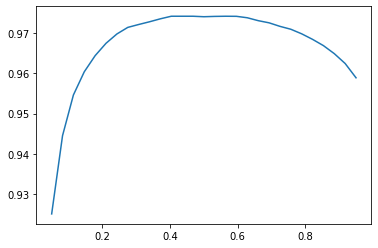

In [42]:
plt.plot(xs, accs)

In [43]:
learn.metrics = partial(accuracy_multi, thresh=.35)

In [44]:
learn.validate()

(#2) [0.07377028465270996,0.9730080366134644]

In [45]:
from fastai.vision.widgets import FileUpload

FileUpload(value={}, description='Upload')

In [119]:
uploader = FileUpload()
uploader

FileUpload(value={}, description='Upload')

In [120]:
img = PILImage.create(uploader.data[0])

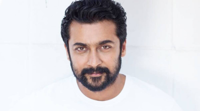

In [121]:
img.to_thumb(200)

In [122]:
learn.predict(img)

(TensorPoint([[144.5849, 140.3921]]),
 tensor([-0.0963,  0.1699]),
 tensor([-0.0963,  0.1699]))

# Regression

In [57]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [58]:
path.ls().sorted()

(#50) [Path('/root/.fastai/data/biwi_head_pose/01'),Path('/root/.fastai/data/biwi_head_pose/01.obj'),Path('/root/.fastai/data/biwi_head_pose/02'),Path('/root/.fastai/data/biwi_head_pose/02.obj'),Path('/root/.fastai/data/biwi_head_pose/03'),Path('/root/.fastai/data/biwi_head_pose/03.obj'),Path('/root/.fastai/data/biwi_head_pose/04'),Path('/root/.fastai/data/biwi_head_pose/04.obj'),Path('/root/.fastai/data/biwi_head_pose/05'),Path('/root/.fastai/data/biwi_head_pose/05.obj')...]

In [59]:
(path/'01').ls().sorted()

(#1000) [Path('/root/.fastai/data/biwi_head_pose/01/depth.cal'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00003_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00003_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00004_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00004_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00005_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00005_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00006_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00006_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00007_pose.txt')...]

In [60]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('/root/.fastai/data/biwi_head_pose/21/frame_00691_pose.txt')

In [63]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

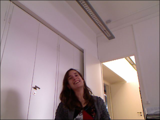

In [64]:
im.to_thumb(160)

In [65]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [66]:
get_ctr(img_files[0])

tensor([317.3501, 305.7254])

In [67]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)]
)

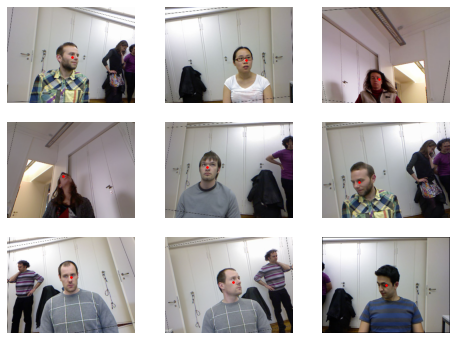

In [68]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [69]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [70]:
yb[0]

TensorPoint([[0.0771, 0.2927]], device='cuda:0')

In [71]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

In [72]:
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.03981071710586548)

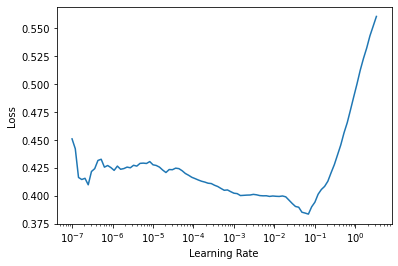

In [73]:
learn.lr_find()

In [74]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.049180,0.003666,01:40


epoch,train_loss,valid_loss,time
0,0.008298,0.000938,02:07
1,0.003411,0.000663,02:06
2,0.001421,0.000147,02:06


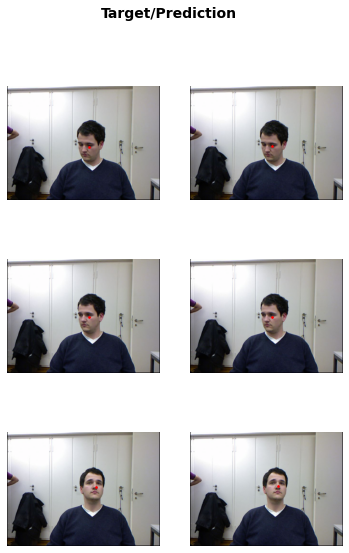

In [75]:
learn.show_results(ds_idx=1, nrows=3)

In [76]:
from fastai.vision.widgets import FileUpload

In [80]:
upload = FileUpload()
upload

FileUpload(value={}, description='Upload')

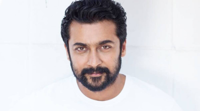

In [108]:
img = PILImage.create(upload.data[0])
img.to_thumb(200)

In [109]:
pred, _, _ = learn.predict(img)
pred

TensorPoint([[144.5849, 140.3921]])

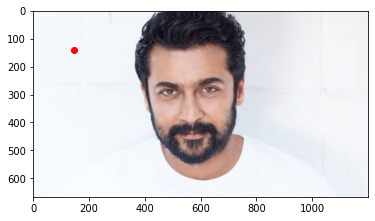

In [115]:
plt.imshow(img)
plt.scatter(pred[0][0], pred[0][1], color='red')